In [1]:
import pandas as pd

In [2]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head()

,image_id,category
0,18540,0
1,18541,0
2,18542,0
3,18543,0
4,18544,0


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
from fastai.vision import *

In [5]:
from pathlib import Path
path = Path('data')

In [6]:
path.ls()

[WindowsPath('data/models'),
 WindowsPath('data/sample_submission.csv'),
 WindowsPath('data/test'),
 WindowsPath('data/test.csv'),
 WindowsPath('data/train'),
 WindowsPath('data/train.csv')]

In [7]:
tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
trn, tes = [ImageList.from_df(df, path=path, cols='image_id', suffix='.jpg', folder=folder)
              for df, folder in zip([train, test], ['train', 'test'])]

In [20]:
data = (trn.split_by_rand_pct(0.3, seed=1)
       .label_from_df(cols='category')
       .transform(tfms, size=256)
       .add_test(tes)
       .databunch(bs=32).normalize(imagenet_stats))

In [ ]:
#data.show_batch(rows=3, figsize=(5,5))

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


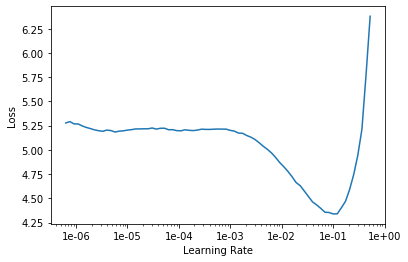

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.862496,0.519888,0.856526,02:00
1,0.211879,0.091283,0.975908,01:58


In [26]:
learn.save('stage-1')

In [27]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


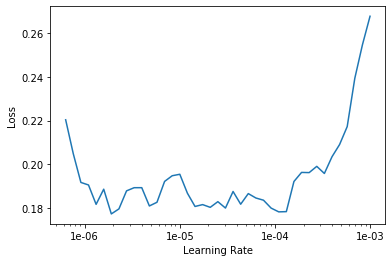

In [28]:
learn.recorder.plot()

In [29]:
learn.save('stage-1')

In [30]:
learn.fit_one_cycle(2, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.141596,0.068363,0.983459,02:16
1,0.119099,0.062114,0.984178,02:18


In [31]:
learn.save('stage-2')

In [32]:
learn.fit(3, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.111562,0.048237,0.987235,02:18
1,0.081922,0.038169,0.991370,02:18
2,0.076555,0.033181,0.992629,02:18


In [33]:
learn.save('stage-3')

In [34]:
learn.fit(2, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.060134,0.026640,0.993707,02:16
1,0.056286,0.024532,0.994426,02:16


In [35]:
learn.save('stage-4')

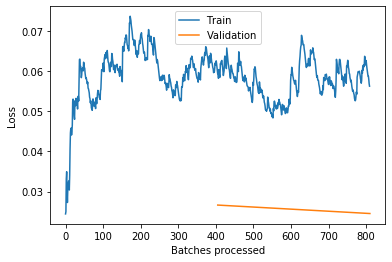

In [39]:
learn.recorder.plot_losses()

# submission

In [36]:
final_preds, y = learn.TTA(ds_type = DatasetType.Test)

In [37]:
sub['category'] = final_preds.argmax(dim=1)+1

In [38]:
sub.to_csv('submission-v2.csv', index=False)

# Bigger Model

In [41]:
learn50 = cnn_learner(data, models.resnet50, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


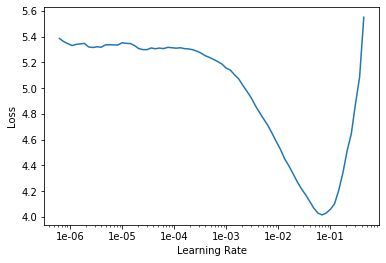

In [42]:
learn50.lr_find()
learn50.recorder.plot()

In [43]:
learn50.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.420815,0.154234,0.955052,03:08


In [44]:
learn50.save('res50-224-stage1')

In [45]:
learn50.unfreeze()
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


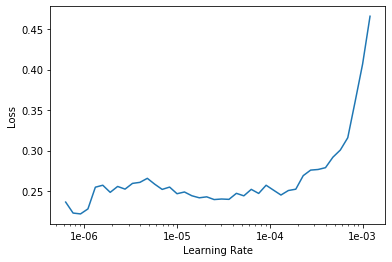

In [46]:
learn50.recorder.plot()

In [48]:
learn50.load('res50-224-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (12978 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
81,52,72,67,51
Path: data;

Valid: LabelList (5562 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
95,94,34,98,77
Path: data;

Test: LabelList (2009 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), str

In [49]:
learn50.fit_one_cycle(3, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.243976,0.109054,0.972132,03:47
1,0.157289,0.077753,0.980223,03:49
2,0.139400,0.069713,0.981661,03:43


In [50]:
learn50.save('res50-224-stage2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


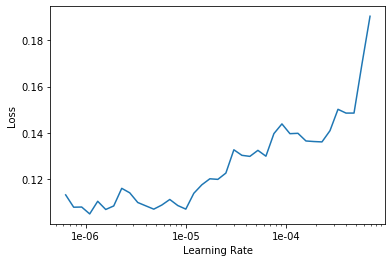

In [51]:
learn50.lr_find()
learn50.recorder.plot()

In [52]:
learn50.fit_one_cycle(5, 8e-7, 1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.125637,0.069531,0.981481,03:50
1,0.131423,0.067140,0.983279,03:49
2,0.120342,0.063788,0.984718,03:44
3,0.134804,0.062259,0.985077,03:49
4,0.113754,0.063508,0.984897,03:42


In [54]:
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback

In [56]:
learn50.fit_one_cycle(20, 3e-7, wd=0, callbacks=[SaveModelCallback(learn50, every='epoch', 
                                                                   monitor='accuracy', name='res50-224-stage3')])

epoch,train_loss,valid_loss,accuracy,time
0,0.130143,0.063689,0.984897,03:48
1,0.117614,0.063057,0.985077,03:42
2,0.121036,0.062442,0.985437,03:40
3,0.123254,0.060427,0.985437,03:43
4,0.120969,0.061321,0.985976,03:43
5,0.117654,0.058630,0.986156,03:44
6,0.114835,0.057389,0.987055,03:44
7,0.108127,0.058094,0.986156,03:43
8,0.113992,0.056794,0.987235,03:44
9,0.111161,0.056729,0.985796,03:44


In [57]:
final_preds, y = learn50.TTA(ds_type = DatasetType.Test)

In [58]:
sub['category'] = final_preds.argmax(dim=1)+1

In [59]:
sub.to_csv('sub-res50-224.csv', index=False)

# ensemble

In [60]:
learn_d1 = cnn_learner(data, models.densenet169, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\michael/.cache\torch\checkpoints\densenet169-b2777c0a.pth
100%|█████████████████████████████████████████████████████████████████| 57365526/57365526 [00:07<00:00, 8127577.51it/s]


In [63]:
torch.cuda.empty_cache()


In [64]:
learn_d1.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 6.19 GiB already allocated; 51.20 KiB free; 46.02 MiB cached)

In [68]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [69]:
learn = load_learner('data/models', 'stage-4.pth')

KeyError: 'data'

In [70]:
learn50.export('res50-trained.pkl')

In [ ]:
learn.load('stage-4')